In [2]:
import numpy as np
import os
import io
import pandas as pd
import tensorflow as tf
from tensorflow.python.client import device_lib
from tensorflow import keras

In [3]:
NetBIOS = pd.read_csv('./DDoS_data/CSV-01-12/01-12/DrDoS_NetBIOS.csv', low_memory=False, nrows=50000)
DNS = pd.read_csv('./DDoS_data/CSV-01-12/01-12/DrDoS_DNS.csv', low_memory=False, nrows=50000)
LDAP = pd.read_csv('./DDoS_data/CSV-01-12/01-12/DrDoS_LDAP.csv', low_memory=False, nrows=50000)
Portmap =  pd.read_csv('./DDoS_data/CSV-03-11/03-11/Portmap.csv', low_memory=False, nrows=50000)

In [4]:
SNMP = pd.read_csv('./DDoS_data/CSV-01-12/01-12/DrDoS_SNMP.csv', low_memory=False, nrows=50000)
SSDP = pd.read_csv('./DDoS_data/CSV-01-12/01-12/DrDoS_SSDP.csv', low_memory=False, nrows=50000)
UDP = pd.read_csv('./DDoS_data/CSV-01-12/01-12/DrDoS_UDP.csv', low_memory=False, nrows=50000)
SYN = pd.read_csv('./DDoS_data/CSV-01-12/01-12/Syn.csv', low_memory=False, nrows=50000)

In [5]:
MSSQL = pd.read_csv('./DDoS_data/CSV-01-12/01-12/DrDoS_MSSQL.csv', low_memory=False, nrows=50000)
NTP = pd.read_csv('./DDoS_data/CSV-01-12/01-12/DrDoS_NTP.csv', low_memory=False, nrows=50000)
TFTP = pd.read_csv('./DDoS_data/CSV-01-12/01-12/TFTP.csv', low_memory=False, nrows=50000)
UDPLag = pd.read_csv('./DDoS_data/CSV-01-12/01-12/UDPLag.csv', low_memory=False, nrows=50000)

In [6]:
reflective_attacks = pd.concat([NetBIOS, DNS, LDAP, Portmap, MSSQL, NTP, SNMP, SSDP, UDP, SYN, TFTP, UDPLag])

In [7]:
reflective_attacks.head()

,Unnamed: 0,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,...,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,SimillarHTTP,Inbound,Label
0,256565,172.16.0.5-192.168.50.1-34012-2334-17,172.16.0.5,34012,192.168.50.1,2334,17,2018-12-01 11:47:08.463789,1,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,DrDoS_NetBIOS
1,252918,172.16.0.5-192.168.50.1-34013-50170-17,172.16.0.5,34013,192.168.50.1,50170,17,2018-12-01 11:47:08.464316,1,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,DrDoS_NetBIOS
2,174257,172.16.0.5-192.168.50.1-34014-61534-17,172.16.0.5,34014,192.168.50.1,61534,17,2018-12-01 11:47:08.464472,1,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,DrDoS_NetBIOS
3,185193,172.16.0.5-192.168.50.1-34015-8930-17,172.16.0.5,34015,192.168.50.1,8930,17,2018-12-01 11:47:08.464520,1,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,DrDoS_NetBIOS
4,198671,172.16.0.5-192.168.50.1-34016-33040-17,172.16.0.5,34016,192.168.50.1,33040,17,2018-12-01 11:47:08.464925,2,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,DrDoS_NetBIOS


In [8]:
reflective_attacks = reflective_attacks.rename(columns={' Label': 'Label'})
reflective_attacks.Label

0        DrDoS_NetBIOS
1        DrDoS_NetBIOS
2        DrDoS_NetBIOS
3        DrDoS_NetBIOS
4        DrDoS_NetBIOS
             ...      
49995           BENIGN
49996           BENIGN
49997           BENIGN
49998           BENIGN
49999           BENIGN
Name: Label, Length: 600000, dtype: object

In [9]:
# Rename the types of attacks
old_labels = ['DrDoS_SSDP', 'DrDoS_LDAP', 'DrDoS_SNMP', 'DrDoS_NetBIOS', 'DrDoS_MSSQL', 'DrDoS_UDP', 'DrDoS_DNS', 'DrDoS_NTP']
new_labels = ['SSDP', 'LDAP', 'SNMP', 'NetBIOS', 'MSSQL', 'UDP', 'DNS', 'NTP']
reflective_attacks['Label'].replace(old_labels, new_labels, inplace=True)

In [10]:
# Drop NaN values
print('There are {} columns and {} rows in the Layer 1 Data.'.format(len(reflective_attacks.columns), len(reflective_attacks)))
reflective_attacks.dropna(axis='index', inplace=True)
reflective_attacks = reflective_attacks[~reflective_attacks.isin([np.nan, np.inf, -np.inf]).any(1)]
print('After dropping NaN values, there are {} columns and {} rows in Layer 1 Data.\n\n'.format(len(reflective_attacks.columns), len(reflective_attacks)))

There are 88 columns and 600000 rows in the Layer 1 Data.
After dropping NaN values, there are 88 columns and 579017 rows in Layer 1 Data.




In [11]:
print(len(reflective_attacks.index))

579017


In [12]:
# Remove overfitting columns (the same ones used in the original paper)
overfitting_columns = ['Unnamed: 0', ' Source IP', ' Destination IP', ' Source Port', ' Destination Port', ' Timestamp', 'SimillarHTTP', 'Flow ID']
reflective_attacks.drop(labels=overfitting_columns, axis='columns', inplace=True)
pd.set_option('display.max_columns', None)

In [13]:
print('After dropping overfitting columns: \n\t there are {} columns and {} rows'.format(len(reflective_attacks.columns), len(reflective_attacks)))

After dropping overfitting columns: 
	 there are 80 columns and 579017 rows


In [14]:
print(reflective_attacks.columns)

Index([' Protocol', ' Flow Duration', ' Total Fwd Packets',
       ' Total Backward Packets', 'Total Length of Fwd Packets',
       ' Total Length of Bwd Packets', ' Fwd Packet Length Max',
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean',
       ' Fwd Packet Length Std', 'Bwd Packet Length Max',
       ' Bwd Packet Length Min', ' Bwd Packet Length Mean',
       ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s',
       ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min',
       'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max',
       ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std',
       ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags',
       ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length',
       ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s',
       ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean',
       ' Packet Length Std', ' Packet Length Variance', 'FIN Flag

In [16]:
# Remove columns with only values of 0
useless_columns = [' Bwd PSH Flags', ' Fwd URG Flags', ' Fwd URG Flags', ' Bwd URG Flags', ' Bwd URG Flags', 'FIN Flag Count',
                   ' PSH Flag Count', ' ECE Flag Count', 'Fwd Avg Bytes/Bulk', ' Fwd Avg Packets/Bulk', ' Fwd Avg Bulk Rate',
                   ' Bwd Avg Bytes/Bulk', ' Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate']
reflective_attacks.drop(labels=useless_columns, axis='columns', inplace=True)
print('After dropping columns with only 0 values: \n\t there are {} columns and {} rows'.format(len(reflecttive_attacks.columns),
                                                                                                len(reflecttive_attacks)))


KeyError: "[' Bwd PSH Flags' ' Fwd URG Flags' ' Fwd URG Flags' ' Bwd URG Flags'\n ' Bwd URG Flags' 'FIN Flag Count' ' PSH Flag Count' ' ECE Flag Count'\n 'Fwd Avg Bytes/Bulk' ' Fwd Avg Packets/Bulk' ' Fwd Avg Bulk Rate'\n ' Bwd Avg Bytes/Bulk' ' Bwd Avg Packets/Bulk' 'Bwd Avg Bulk Rate'] not found in axis"

In [18]:
reflective_attacks['Label'].value_counts()


SSDP       49762
SNMP       49395
UDP        49035
MSSQL      48931
LDAP       48766
UDP-lag    48001
NetBIOS    46777
DNS        46492
Syn        45722
TFTP       44791
Portmap    42596
NTP        37375
BENIGN     21232
WebDDoS      142
Name: Label, dtype: int64

<AxesSubplot:>

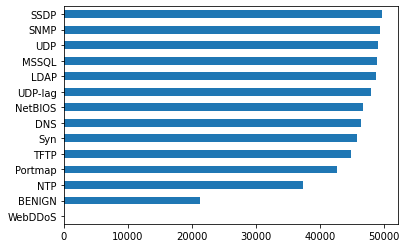

In [23]:
reflective_attacks['Label'].value_counts().sort_values().plot(kind = 'barh')

In [24]:
from scipy.stats import pearsonr 
import matplotlib.pyplot as plt
import seaborn as sns